### Ch:3 - Apply PCA on MSD Heart dataset and compare PC1 and PC2

In [44]:
import os
import time
start_time=time.time()
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import torch
from torchvision import transforms
from sklearn.decomposition import PCA

In [45]:
#location of heart dataset
img_dir = "all_bucket/marketplace-c3kdc8vj/Medical Decathlon Heart/146/artifactFiles/imagesTs"

In [46]:
#load DINO ResNet50 model
# Load the DINO ResNet-50 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load the DINO ResNet-50 model
resnet50 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
resnet50.to(device)
resnet50.eval()

Using device: cuda


Using cache found in /home/jupyter/.cache/torch/hub/facebookresearch_dino_main
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
# Function to extract features from a 2D slice
def extract_features(slice_2d):
    # Stack the 2D slice into three identical channels
    slice_3d = np.stack([slice_2d] * 3, axis=-1)
    
    # Normalize the slice to the range [0, 255] and convert to uint8
    min_val = np.min(slice_3d)
    max_val = np.max(slice_3d)
    if max_val > min_val:
        slice_3d = (slice_3d - min_val) / (max_val - min_val) * 255
    else:
        slice_3d = np.zeros_like(slice_3d)  # Set to zero if min and max are the same
    slice_3d = slice_3d.astype(np.uint8)
    
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(slice_3d)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        features = resnet50(input_batch)
    return features.cpu().numpy()

# Iterate over each file in the directory

features_modality_1=[]
for filename in os.listdir(img_dir):
    if filename.endswith(".nii.gz"):
        # Load the image
        image = sitk.ReadImage(os.path.join(img_dir, filename))
        image_array = sitk.GetArrayFromImage(image)

#         # Extract and average features for each slice in the first modality (index 0)
        file_features_modality_1 = []
        for slice_idx in range(image_array.shape[2]):
            slice_2d = image_array[:, :, slice_idx]
            features = extract_features(slice_2d)
            file_features_modality_1.append(features)
#         # Average over the channel dimension
        avg_features_modality_1 = np.mean(file_features_modality_1, axis=0)
        print(avg_features_modality_1.shape)
        features_modality_1.append(avg_features_modality_1.flatten())
  

        

# # Convert lists to numpy arrays
features_modality_1 = np.array(features_modality_1)
# features_modality_2 = np.array(features_modality_2)

(1, 2048)
(1, 2048)
(1, 2048)
(1, 2048)
(1, 2048)
(1, 2048)
(1, 2048)
(1, 2048)
(1, 2048)
(1, 2048)


In [48]:
# Initialize PCA to reduce to 2 components
pca = PCA(n_components=2)

# Fit and transform the data
principal_components = pca.fit_transform(features_modality_1)

# principal_components will have shape [10, 2]
print("Principal Components shape:", principal_components.shape)

Principal Components shape: (10, 2)


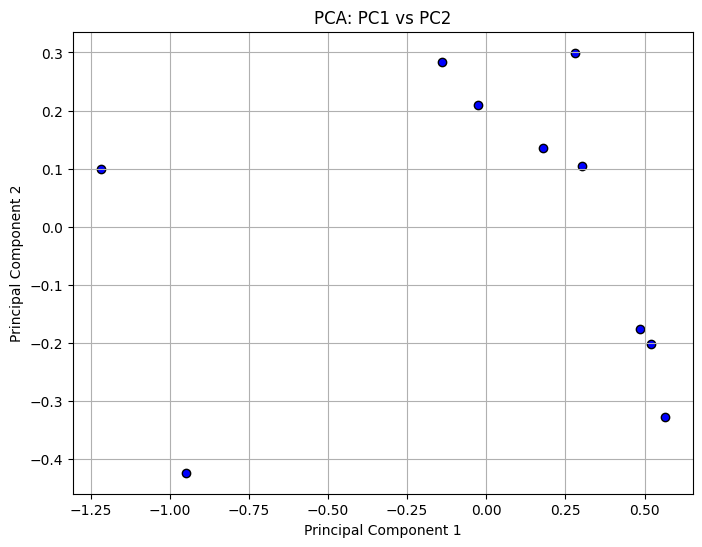

In [49]:
# Plot PC1 vs PC2
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], color='blue', edgecolor='k')
plt.title('PCA: PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [50]:
end_time=time.time()
total_time= end_time-start_time
print(f"total_time is {total_time}")

total_time is 58.40530276298523
